We will first acquire the necessary credentials to access the Spark cluster.

In [1]:
import getpass
import os, sys

print("Please enter your password")
ret = os.system("echo \"%s\" | kinit" % getpass.getpass())

if ret == 0: print("Credentials created successfully")
else:        sys.stderr.write('Error creating credentials, return code: %s\n' % ret)

Please enter your password
········
Credentials created successfully


Next, some Spark imports.

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

Now we will create the SparkContext, where we will configure the Spark driver to connect to the previously selected cluster. Note that this cell will take some time to run since it triggers the first connection to the cluster.

It is worth pointing out that **this configuration step will be automatized**: a graphical interface will hide most of these configuration options and allow to set other parameters like the number of executors.

In [3]:
conf = SparkConf()
conf.set('spark.driver.host', os.environ['SERVER_HOSTNAME'])
conf.set('spark.driver.port', os.environ['SPARK_PORT_1'])
conf.set('spark.blockManager.port', os.environ['SPARK_PORT_2'])
conf.set('spark.ui.port', os.environ['SPARK_PORT_3'])
conf.set('spark.master', 'yarn')
conf.set('spark.authenticate', True)
conf.set('spark.network.crypto.enabled', True)
conf.set('spark.authenticate.enableSaslEncryption', True)
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

Load the datasets

In [4]:
ratings = spark.read.option("header","true").csv("/user/pkothuri/sparkTraining/ratings.csv")

In [6]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



In [7]:
movies = spark.read.option("header","true").csv("/user/pkothuri/sparkTraining/movies.csv")

In [26]:
movies.show(5, False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [22]:
tags = spark.read.option("header","true").csv("/user/pkothuri/sparkTraining/tags.csv")

In [23]:
tags.show(5)

+------+-------+----------+----------+
|userId|movieId|       tag| timestamp|
+------+-------+----------+----------+
|     1|    318|  narrated|1425942391|
|    20|   4306|Dreamworks|1459855607|
|    20|  89302|   England|1400778834|
|    20|  89302| espionage|1400778836|
|    20|  89302|      jazz|1400778841|
+------+-------+----------+----------+
only showing top 5 rows



Register the dataframes as tables

In [24]:
ratings.createOrReplaceTempView("ratings")
movies.createOrReplaceTempView("movies")
tags.createOrReplaceTempView("tags")

How many movies produced per year?

In [42]:
from pyspark.sql.functions import regexp_extract
movies_year = movies.withColumn("Year",regexp_extract("title",'^(.*) \\(([0-9 \\-]*)\\)$',2))
movies_year.show(5,False)
movies_year.createOrReplaceTempView("movies_year")

+-------+----------------------------------+-------------------------------------------+----+
|movieId|title                             |genres                                     |Year|
+-------+----------------------------------+-------------------------------------------+----+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995|
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995|
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995|
+-------+----------------------------------+-------------------------------------------+----+
only showing top 5 rows



In [61]:
m_yr = spark.sql("select year, count(1) as count from movies_year group by year order by year").toPandas()

In [74]:
spark.sql("select count(1) from movies_year where year = 0").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [54]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

<IPython.core.display.Javascript object>


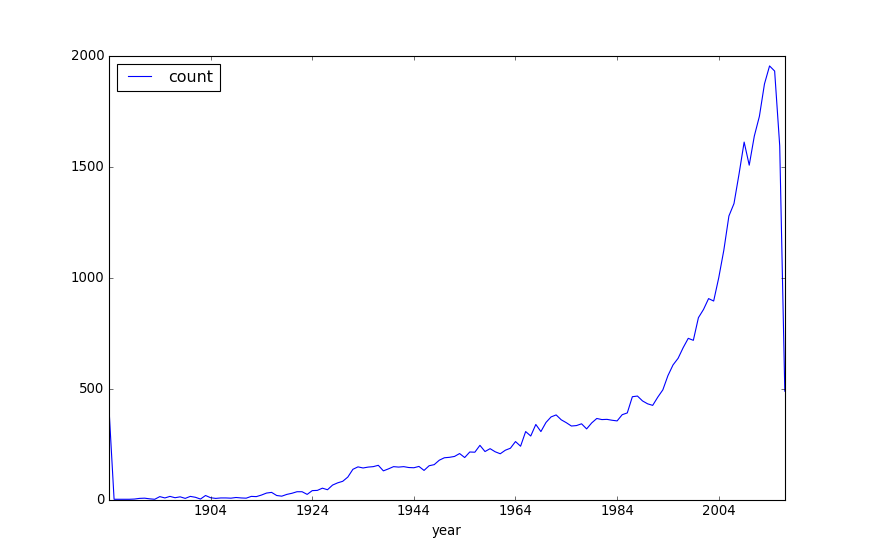

In [65]:
m_yr.plot(x='year',y='count',kind='line')

Top movies by number of ratings

In [13]:
spark.sql("select title, count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").show(5)

+--------------------+--------+
|               title|count(1)|
+--------------------+--------+
| Forrest Gump (1994)|   91921|
|Shawshank Redempt...|   91082|
| Pulp Fiction (1994)|   87901|
|Silence of the La...|   84078|
|  Matrix, The (1999)|   77960|
+--------------------+--------+
only showing top 5 rows



What happened in the background? How did the join happen?

In [14]:
spark.sql("select title, count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").explain()

== Physical Plan ==
*Sort [count(1)#77L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(count(1)#77L DESC NULLS LAST, 200)
   +- *HashAggregate(keys=[title#20], functions=[count(1)])
      +- Exchange hashpartitioning(title#20, 200)
         +- *HashAggregate(keys=[title#20], functions=[partial_count(1)])
            +- *Project [title#20]
               +- *BroadcastHashJoin [movieId#19], [movieId#1], Inner, BuildLeft
                  :- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, true]))
                  :  +- *Project [movieId#19, title#20]
                  :     +- *Filter isnotnull(movieId#19)
                  :        +- *FileScan csv [movieId#19,title#20] Batched: false, Format: CSV, Location: InMemoryFileIndex[hdfs://p01001532067275.cern.ch/user/pkothuri/sparkTraining/movies.csv], PartitionFilters: [], PushedFilters: [IsNotNull(movieId)], ReadSchema: struct<movieId:string,title:string>
                  +- *Project [movieId#1]
               

How is the query optimised? Can we get more information?

In [16]:
spark.sql("select title, count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").explain(True)

== Parsed Logical Plan ==
'Sort [2 DESC NULLS LAST], true
+- 'Aggregate ['title], ['title, unresolvedalias('count(1), None)]
   +- 'Filter ('m.movieId = 'r.movieId)
      +- 'Join Inner
         :- 'UnresolvedRelation `movies`, m
         +- 'UnresolvedRelation `ratings`, r

== Analyzed Logical Plan ==
title: string, count(1): bigint
Sort [count(1)#91L DESC NULLS LAST], true
+- Aggregate [title#20], [title#20, count(1) AS count(1)#91L]
   +- Filter (movieId#19 = movieId#1)
      +- Join Inner
         :- SubqueryAlias m, `movies`
         :  +- Relation[movieId#19,title#20,genres#21] csv
         +- SubqueryAlias r, `ratings`
            +- Relation[userId#0,movieId#1,rating#2,timestamp#3] csv

== Optimized Logical Plan ==
Sort [count(1)#91L DESC NULLS LAST], true
+- Aggregate [title#20], [title#20, count(1) AS count(1)#91L]
   +- Project [title#20]
      +- Join Inner, (movieId#19 = movieId#1)
         :- Project [movieId#19, title#20]
         :  +- Filter isnotnull(movieId#19)
     

Top movies by ratings

In [17]:
spark.sql("select title, avg(rating) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").show(5)

+--------------------+---------------------------+
|               title|avg(CAST(rating AS DOUBLE))|
+--------------------+---------------------------+
|  Dark Harbor (1999)|                        5.0|
|The Hardy Bucks M...|                        5.0|
|Hush Little Baby ...|                        5.0|
|Jimi Plays Berkel...|                        5.0|
|Gentleman's Game,...|                        5.0|
+--------------------+---------------------------+
only showing top 5 rows



Really? How many reviews contributed to this rating?

In [18]:
spark.sql("select title, avg(rating), count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").show(5)

+--------------------+---------------------------+--------+
|               title|avg(CAST(rating AS DOUBLE))|count(1)|
+--------------------+---------------------------+--------+
|Hush Little Baby ...|                        5.0|       1|
|  Dark Harbor (1999)|                        5.0|       1|
|Gentleman's Game,...|                        5.0|       1|
|Jimi Plays Berkel...|                        5.0|       1|
|The Hardy Bucks M...|                        5.0|       1|
+--------------------+---------------------------+--------+
only showing top 5 rows



In [19]:
spark.sql("select count(*) from ratings").show()

+--------+
|count(1)|
+--------+
|26024289|
+--------+



In [21]:
spark.sql("select count(*) from ratings")

== Parsed Logical Plan ==
'Project [unresolvedalias('count(1), None)]
+- 'UnresolvedRelation `ratings`

== Analyzed Logical Plan ==
count(1): bigint
Aggregate [count(1) AS count(1)#156L]
+- SubqueryAlias ratings, `ratings`
   +- Relation[userId#0,movieId#1,rating#2,timestamp#3] csv

== Optimized Logical Plan ==
Aggregate [count(1) AS count(1)#156L]
+- Project
   +- Relation[userId#0,movieId#1,rating#2,timestamp#3] csv

== Physical Plan ==
*HashAggregate(keys=[], functions=[count(1)], output=[count(1)#156L])
+- Exchange SinglePartition
   +- *HashAggregate(keys=[], functions=[partial_count(1)], output=[count#160L])
      +- *FileScan csv [] Batched: false, Format: CSV, Location: InMemoryFileIndex[hdfs://p01001532067275.cern.ch/user/pkothuri/sparkTraining/ratings.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<>


In [80]:
spark.sql('select count(tag) from tags t, movies m where t.movieId = m.movieId and genres like "%Comedy%"').show(5)

+----------+
|count(tag)|
+----------+
|    208848|
+----------+



ImportError: No module named wordcloud